Questions:

	1.	General Understanding:
	•	“How does exposure to environmental substances lead to cancer?”
	•	“What is the two-step process of tumorigenesis?”
	•	“How does PM2.5 contribute to lung cancer development?”
	2.	Specific Associations:
	•	“What is the role of PM2.5 in lung cancer?”
	•	“How is lung cancer associated with environmental particulate matter?”
	•	“Which type of lung cancer is more common in never-smokers or light smokers?”
	3.	Scientific Findings:
	•	“What did the study find about EGFR-driven lung cancer cases?”
	•	“How do air pollutants affect macrophages in the lung?”
	•	“What were the results from ultradeep mutational profiling?”
	4.	Technical Details:
	•	“What is the significance of interleukin-1β in lung cancer progression?”
	•	“What are the mutations found in healthy lung tissue related to cancer?”
	•	“How does air pollution influence cancer mutation rates?”
	5.	Implications and Recommendations:
	•	“Why is it important to reduce PM2.5 levels?”
	•	“What public health measures could address the link between air pollution and cancer?”
	•	“What can be done to lower the risk of lung cancer in urban areas?”

These queries cover a range of contexts and details to test the embedding models on different aspects of the provided text.

-> Now we have 4 embedding models

-> Taken one chunk from the lung cancer PMC Article <br>
-> Tried out different combinations and orderings of the chunk and created embeddings <br>
-> For 1 user query tried out retriveal from the various combinations and saw the scores and embeddings visually <br>

->See how each model and strategy is performing on a smaller scale for just one chunk

# Legends:

- caps - Chunk with Annotations Prepended and Summary 
- cap - Chunk with Annotations Prepended and NO Summary
- cais - Chunk with Annotations Inline and Summary 
- cai - Chunk with Annotations Inline and NO Summary

In [145]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

def masked_mean_pooling(token_embeddings, attention_mask):
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    valid_token_count = input_mask_expanded.sum(dim=1).clamp(min=1e-9)
    mean_embeddings = sum_embeddings / valid_token_count
    return mean_embeddings


def get_embeddings(model_name, texts, token_limit=512, stride=None):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    max_length = token_limit
    stride = stride or max_length // 2

    all_embeddings = []

    for text in texts:
        tokens = tokenizer.encode(text, add_special_tokens=False)

        if len(tokens) <= max_length:
            # print("tokens: ", len(tokens), "small")
            inputs = tokenizer(
                text,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=max_length,
            )
            with torch.no_grad():
                outputs = model(**inputs)
            embeddings = masked_mean_pooling(
                outputs.last_hidden_state, inputs["attention_mask"]
            )
        else:
            # print("tokens: ", len(tokens), "large")
            chunk_embeddings = []
            chunk_masks = []
            for i in range(0, len(tokens), stride):
                chunk_tokens = tokens[i : i + max_length]

                # Convert tokens back to text
                chunk_text = tokenizer.decode(chunk_tokens)
                # Tokenize again with special tokens and padding
                chunk_inputs = tokenizer(
                    chunk_text,
                    return_tensors="pt",
                    padding="max_length",
                    truncation=True,
                    max_length=max_length,
                )

                with torch.no_grad():
                    chunk_outputs = model(**chunk_inputs)
                chunk_embeddings.append(chunk_outputs.last_hidden_state)
                chunk_masks.append(chunk_inputs["attention_mask"])

            # Combine chunk embeddings using masked mean pooling
            combined_embeddings = torch.cat(chunk_embeddings, dim=1)
            combined_mask = torch.cat(chunk_masks, dim=1)
            embeddings = masked_mean_pooling(combined_embeddings, combined_mask)

        # Normalize embeddings
        embeddings = F.normalize(embeddings, p=2, dim=1)
        all_embeddings.append(embeddings)

    # Stack all embeddings
    return torch.cat(all_embeddings, dim=0)

In [146]:
import matplotlib.pyplot as plt
import numpy as np

def get_similarity_scores(model_similarity, model_name):

    # similarity_scores = np.array([0.89330935, 0.88667977, 0.87620276, 0.86875135])
    # Ensure the scores are a 1D numpy array
    similarity_scores = np.array(model_similarity).flatten()
    # Labels for each text
    # chunk_caps, chunk_cap, chunk_cais, chunk_cai
    labels = ['chunk_caps', 'chunk_cap', 'chunk_cais', 'chunk_cai']
    
    # Plotting the bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(labels, similarity_scores, color='skyblue')
    
    # Adding title and labels
    plt.title(f'Similarity between Query and Texts using {model_name} (using 1 chunk)', fontsize=14)
    plt.xlabel('Texts', fontsize=12)
    plt.ylabel('Similarity Score', fontsize=12)
    
    # Display the similarity score on top of each bar
    for i, score in enumerate(similarity_scores):
        plt.text(i, score + 0.005, f'{score:.4f}', ha='center', fontsize=10)
    
    # Show plot
    plt.ylim(0, 1.0)  # Adjust y-axis for better visibility
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [147]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def plot_embeddings_tsne_2d(user_query_embeddings, text_embeddings, model_name):
    embeddings = np.vstack([user_query_embeddings, text_embeddings])

    labels = ['chunk_caps', 'chunk_cap', 'chunk_cais', 'chunk_cai']

    # Ensure perplexity is valid for small sample sizes
    n_samples = embeddings.shape[0]
    perplexity = min(5, n_samples - 1)  # Perplexity should be less than n_samples

    # Apply t-SNE with a valid perplexity
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Separate the reduced embeddings
    query_reduced = embeddings_2d[0]
    text_reduced = embeddings_2d[1:]

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(text_reduced[:, 0], text_reduced[:, 1], c='blue', label='Text Embeddings')
    for i, txt in enumerate(range(1, len(text_reduced) + 1)):
        plt.annotate(f'{labels[i]}', (text_reduced[i, 0], text_reduced[i, 1]))
    plt.scatter(query_reduced[0], query_reduced[1], c='red', label='Query Embedding', s=100)
    plt.annotate('Query', (query_reduced[0], query_reduced[1]), xytext=(5, 5), textcoords='offset points')

    title = f'2D Visualization of Query and Text Embeddings using {model_name}'
    plt.title(title, fontsize=14)
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.legend()
    plt.show()

In [148]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_embeddings_tsne_2d_claude(user_query_embeddings, embeddings, model_name):
    # Assuming you have these variables:
    # query_embedding: torch.Tensor of shape (1, 768)
    # entire_text_embedding: torch.Tensor of shape (4, 768)
    labels = ['chunk_caps', 'chunk_cap', 'chunk_cais', 'chunk_cai']
    # Convert PyTorch tensors to numpy arrays
    query_embedding_np = user_query_embeddings.cpu().numpy()
    entire_text_embedding_np = embeddings.cpu().numpy()
    
    # Combine the embeddings
    combined_embeddings = np.vstack([query_embedding_np, entire_text_embedding_np])
    
    # Calculate the appropriate perplexity
    n_samples = combined_embeddings.shape[0]
    perplexity = min(30, n_samples - 1)  # Default is 30, but we ensure it's less than n_samples
    
    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    reduced_embeddings = tsne.fit_transform(combined_embeddings)
    
    # Separate the reduced embeddings
    query_reduced = reduced_embeddings[0]
    text_reduced = reduced_embeddings[1:]
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(text_reduced[:, 0], text_reduced[:, 1], c='blue', label='Text Embeddings')
    for i, txt in enumerate(range(1, len(text_reduced) + 1)):
        plt.annotate(f'{labels[i]}', (text_reduced[i, 0], text_reduced[i, 1]))
    plt.scatter(query_reduced[0], query_reduced[1], c='red', label='Query Embedding', s=100)
    plt.annotate('Query', (query_reduced[0], query_reduced[1]), xytext=(5, 5), textcoords='offset points')
    
    # Add labels and title
    title = f"2D Visualization of Query and Text Embeddings using {model_name}"
    plt.title(title)
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [149]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

def plot_embeddings_tsne_3d(user_query_embeddings, text_embeddings, model_name):
    # Assuming you have these variables:
    # query_embedding: torch.Tensor of shape (1, 768)
    # entire_text_embedding: torch.Tensor of shape (4, 768)
    
    labels = ['chunk_caps', 'chunk_cap', 'chunk_cais', 'chunk_cai']
    # Convert PyTorch tensors to numpy arrays
    query_embedding_np = user_query_embeddings.cpu().numpy()
    entire_text_embedding_np = text_embeddings.cpu().numpy()
    
    # Combine the embeddings
    combined_embeddings = np.vstack([query_embedding_np, entire_text_embedding_np])
    
    # Calculate the appropriate perplexity
    n_samples = combined_embeddings.shape[0]
    perplexity = min(30, n_samples - 1)  # Default is 30, but we ensure it's less than n_samples
    
    # Apply t-SNE for dimensionality reduction (3D)
    tsne = TSNE(n_components=3, random_state=42, perplexity=perplexity)
    reduced_embeddings = tsne.fit_transform(combined_embeddings)
    
    # Separate the reduced embeddings
    query_reduced = reduced_embeddings[0]
    text_reduced = reduced_embeddings[1:]
    
    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot text embeddings
    scatter_text = ax.scatter(text_reduced[:, 0], text_reduced[:, 1], text_reduced[:, 2],s=100, c='blue', label='Text Embeddings')
    for i, txt in enumerate(range(1, len(text_reduced) + 1)):
        ax.text(text_reduced[i, 0], text_reduced[i, 1], text_reduced[i, 2], f'{labels[i]}', size=8)
    
    # Plot query embedding
    scatter_query = ax.scatter(query_reduced[0], query_reduced[1], query_reduced[2], c='red', s=150, label='Query Embedding')
    ax.text(query_reduced[0], query_reduced[1], query_reduced[2], 'Query', size=10, color='red')
    
    title = f'3D Visualization of Query and Text Embeddings using {model_name}'
    # Add labels and title
    ax.set_title(title)
    ax.set_xlabel('t-SNE dimension 1')
    ax.set_ylabel('t-SNE dimension 2')
    ax.set_zlabel('t-SNE dimension 3')
    ax.legend()
    
    # Show the plot
    plt.tight_layout()
    # # Adjust the view angle for better initial visualization
    # ax.view_init(elev=20, azim=45)
    plt.show()

In [150]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_embeddings_tsne_3d_chatgpt(user_query_embeddings, text_embeddings, model_name):
    
    embeddings = np.vstack([user_query_embeddings, text_embeddings])
    
    labels = ['Query'] + ['chunk_caps', 'chunk_cap', 'chunk_cais', 'chunk_cai']
        
    n_samples = embeddings.shape[0]
    perplexity = min(30, n_samples - 1)  # Ensure perplexity is valid

    # Apply t-SNE with 3 components
    tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42)
    embeddings_3d = tsne.fit_transform(embeddings)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], 
               c='blue', s=100)

    # Add labels if provided
    if labels:
        for i, label in enumerate(labels):
            ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], 
                    label, fontsize=9)
    
    title = f'Visualization of Query and Text Embeddings using {model_name}'
    ax.set_title(title, fontsize=14)
    plt.show()

In [151]:
#### Prepended Annotations and Summary

chunk_caps = """
Summary:
Air pollution promotes lung cancer by inducing inflammation and expanding pre-existing oncogenic mutations. Particulate matter (PM2.5) exposure correlates with increased EGFR-driven lung cancer incidence across countries. PM2.5 triggers macrophage-derived interleukin-1β release, promoting a progenitor-like state in EGFR-mutant lung cells and accelerating tumor formation. Oncogenic EGFR and KRAS mutations were found in 18% and 53% of healthy lung samples, respectively, suggesting air pollutants may promote expansion of existing mutant clones rather than directly causing mutations.

Annotations:
Text - GFR 
Type - Gene
NCBI Gene - 13649
Text - RAS 
Type - Gene
NCBI Gene - 16653
Text - mouse
Type - Species
NCBI Taxonomy - 10090
Text - EGFR
Type - Gene
NCBI Gene - 13649
Text - KRAS
Type - Gene
NCBI Gene - 16653

Text:
A complete understanding of how exposure to environmental substances promotes cancer formation is lacking. More than 70 years ago, tumorigenesis was proposed to occur in a two-step process: an initiating step that induces mutations in healthy cells, followed by a promoter step that triggers cancer development1. Here we propose that environmental particulate matter measuring ≤2.5 μm (PM2.5), known to be associated with lung cancer risk, promotes lung cancer by acting on cells that harbour pre-existing oncogenic mutations in healthy lung tissue. Focusing on EGFR-driven lung cancer, which is more common in never-smokers or light smokers, we found a significant association between PM2.5 levels and the incidence of lung cancer for 32,957 EGFR driven lung cancer cases in four within-country cohorts. Functional mouse models revealed that air pollutants cause an influx of macrophages into the lung and release of interleukin-1β. This process results in a progenitor-like cell state within EGFR mutant lung alveolar type II epithelial cells that fuels tumorigenesis. Ultradeep mutational profiling of histologically normal lung tissue from 295 individuals across 3 clinical cohorts revealed oncogenic EGFR and KRAS driver mutations in 18% and 53% of healthy tissue samples, respectively. These findings collectively support a tumour promoting role for PM2.5 air pollutants and provide impetus for public health policy initiatives to address air pollution to reduce disease burden.      
"""

#### Prepended Annotations and NO Summary

chunk_cap = """
Annotations:
Text - GFR 
Type - Gene
NCBI Gene - 13649
Text - RAS 
Type - Gene
NCBI Gene - 16653
Text - mouse
Type - Species
NCBI Taxonomy - 10090
Text - EGFR
Type - Gene
NCBI Gene - 13649
Text - KRAS
Type - Gene
NCBI Gene - 16653

Text:
A complete understanding of how exposure to environmental substances promotes cancer formation is lacking. More than 70 years ago, tumorigenesis was proposed to occur in a two-step process: an initiating step that induces mutations in healthy cells, followed by a promoter step that triggers cancer development1. Here we propose that environmental particulate matter measuring ≤2.5 μm (PM2.5), known to be associated with lung cancer risk, promotes lung cancer by acting on cells that harbour pre-existing oncogenic mutations in healthy lung tissue. Focusing on EGFR-driven lung cancer, which is more common in never-smokers or light smokers, we found a significant association between PM2.5 levels and the incidence of lung cancer for 32,957 EGFR driven lung cancer cases in four within-country cohorts. Functional mouse models revealed that air pollutants cause an influx of macrophages into the lung and release of interleukin-1β. This process results in a progenitor-like cell state within EGFR mutant lung alveolar type II epithelial cells that fuels tumorigenesis. Ultradeep mutational profiling of histologically normal lung tissue from 295 individuals across 3 clinical cohorts revealed oncogenic EGFR and KRAS driver mutations in 18% and 53% of healthy tissue samples, respectively. These findings collectively support a tumour promoting role for PM2.5 air pollutants and provide impetus for public health policy initiatives to address air pollution to reduce disease burden.
"""


#### Inline Annotations and Summary

chunk_cais = """
Summary:
Air pollution promotes lung cancer by inducing inflammation and expanding pre-existing oncogenic mutations. Particulate matter (PM2.5) exposure correlates with increased EGFR-driven lung cancer incidence across countries. PM2.5 triggers macrophage-derived interleukin-1β release, promoting a progenitor-like state in EGFR-mutant lung cells and accelerating tumor formation. Oncogenic EGFR and KRAS mutations were found in 18% and 53% of healthy lung samples, respectively, suggesting air pollutants may promote expansion of existing mutant clones rather than directly causing mutations.

Text:
A complete understanding of how exposure to environmental substances promotes cancer formation is lacking. More than 70 years ago, tumorigenesis was proposed to occur in a two-step process: an initiating step that induces mutations in healthy cells, followed by a promoter step that triggers cancer development1. Here we propose that environmental particulate matter measuring ≤2.5 μm (PM2.5), known to be associated with lung cancer risk, promotes lung cancer by acting on cells that harbour pre-existing oncogenic mutations in healthy lung tissue. Focusing on EGFR << Type-Gene, NCBI Label-NCBI Gene, NCBI Id-13649 >>-driven lung cancer, which is more common in never-smokers or light smokers, we found a significant association between PM2.5 levels and the incidence of lung cancer for 32,957 EGFR << Type-Gene, NCBI Label-NCBI Gene, NCBI Id-13649 >> driven lung cancer cases in four within-country cohorts. Functional mouse << Type-Species, NCBI Label-NCBI Taxonomy, NCBI Id-10090 >> models revealed that air pollutants cause an influx of macrophages into the lung and release of interleukin-1β. This process results in a progenitor-like cell state within EGFR << Type-Gene, NCBI Label-NCBI Gene, NCBI Id-13649 >> mutant lung alveolar type II epithelial cells that fuels tumorigenesis. Ultradeep mutational profiling of histologically normal lung tissue from 295 individuals across 3 clinical cohorts revealed oncogenic EGFR << Type-Gene, NCBI Label-NCBI Gene, NCBI Id-13649 >> and KRAS << Type-Gene, NCBI Label-NCBI Gene, NCBI Id-16653 >> driver mutations in 18% and 53% of healthy tissue samples, respectively. These findings collectively support a tumour promoting role for PM2.5 air pollutants and provide impetus for public health policy initiatives to address air pollution to reduce disease burden.
"""

#### Inline Annotations and NO Summary

chunk_cai = """
Text:
A complete understanding of how exposure to environmental substances promotes cancer formation is lacking. More than 70 years ago, tumorigenesis was proposed to occur in a two-step process: an initiating step that induces mutations in healthy cells, followed by a promoter step that triggers cancer development1. Here we propose that environmental particulate matter measuring ≤2.5 μm (PM2.5), known to be associated with lung cancer risk, promotes lung cancer by acting on cells that harbour pre-existing oncogenic mutations in healthy lung tissue. Focusing on EGFR << Type-Gene, NCBI Label-NCBI Gene, NCBI Id-13649 >>-driven lung cancer, which is more common in never-smokers or light smokers, we found a significant association between PM2.5 levels and the incidence of lung cancer for 32,957 EGFR << Type-Gene, NCBI Label-NCBI Gene, NCBI Id-13649 >> driven lung cancer cases in four within-country cohorts. Functional mouse << Type-Species, NCBI Label-NCBI Taxonomy, NCBI Id-10090 >> models revealed that air pollutants cause an influx of macrophages into the lung and release of interleukin-1β. This process results in a progenitor-like cell state within EGFR << Type-Gene, NCBI Label-NCBI Gene, NCBI Id-13649 >> mutant lung alveolar type II epithelial cells that fuels tumorigenesis. Ultradeep mutational profiling of histologically normal lung tissue from 295 individuals across 3 clinical cohorts revealed oncogenic EGFR << Type-Gene, NCBI Label-NCBI Gene, NCBI Id-13649 >> and KRAS << Type-Gene, NCBI Label-NCBI Gene, NCBI Id-16653 >> driver mutations in 18% and 53% of healthy tissue samples, respectively. These findings collectively support a tumour promoting role for PM2.5 air pollutants and provide impetus for public health policy initiatives to address air pollution to reduce disease burden.
"""

chunks_strategies = [chunk_caps, chunk_cap, chunk_cais, chunk_cai]

In [152]:
# List of models with their specific token limits
models = [
    ("dmis-lab/biobert-v1.1", 512),
    ("microsoft/biogpt", 1024),
    ("allenai/longformer-base-4096", 4096),
    ("allenai/scibert_scivocab_uncased", 512)
]

In [153]:
# Create Embeddings
## 4 variable with the embeddings
# Try out for each model, embed all the strategies
biobert_embeddings = get_embeddings("dmis-lab/biobert-v1.1", chunks_strategies, 512)

biogpt_embeddings = get_embeddings("microsoft/biogpt", chunks_strategies, 1024)

longformer_embeddings = get_embeddings("allenai/longformer-base-4096", chunks_strategies, 4096)

scibert_embeddings = get_embeddings("allenai/scibert_scivocab_uncased", chunks_strategies, 512)


Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors


In [157]:
# User Query
## Embed User query with 4 embedding models
## Store the user query embeddings in 4 variable
user_query = "What is the role of PM2.5 in lung cancer?"

# user_query = "significance of interleukin-1β in lung cancer progression"
user_query_biobert_embeddings = get_embeddings("dmis-lab/biobert-v1.1", [user_query], 512)

user_query_biogpt_embeddings = get_embeddings("microsoft/biogpt", [user_query], 1024)

user_query_longformer_embeddings = get_embeddings("allenai/longformer-base-4096", [user_query], 4096)

user_query_scibert_embeddings = get_embeddings("allenai/scibert_scivocab_uncased", [user_query], 512)

In [158]:
# Cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between query and text embeddings
biobert_similarity = cosine_similarity(user_query_biobert_embeddings, biobert_embeddings)

biogpt_similarity = cosine_similarity(user_query_biogpt_embeddings, biogpt_embeddings)

longformer_similarity = cosine_similarity(user_query_longformer_embeddings, longformer_embeddings)

scibert_similarity = cosine_similarity(user_query_scibert_embeddings, scibert_embeddings)

print(f"Similarity between query and text using BioBERT: {biobert_similarity}")

print(f"Similarity between query and text using BioGPT: {biogpt_similarity}")

print(f"Similarity between query and text using Longformer: {longformer_similarity}")

print(f"Similarity between query and text using SciBERT: {scibert_similarity}")

Similarity between query and text using BioBERT: [[0.89330935 0.88667977 0.87620276 0.86875135]]
Similarity between query and text using BioGPT: [[0.55350566 0.57370937 0.5299208  0.5438783 ]]
Similarity between query and text using Longformer: [[0.9333886  0.9058332  0.93502545 0.9153023 ]]
Similarity between query and text using SciBERT: [[0.6759476  0.7604351  0.63909054 0.6939694 ]]


Note that the t-SNE visualization provides an approximate projection of high-dimensional embeddings into a lower-dimensional (2D/3D) space. While it helps to identify patterns and clusters, it may not perfectly preserve the relationships or distances from the original space. The visual separation or proximity of points may differ slightly from the actual similarities in the high-dimensional embeddings. Thus, the plot should be interpreted as a visual aid rather than an exact representation of the data.

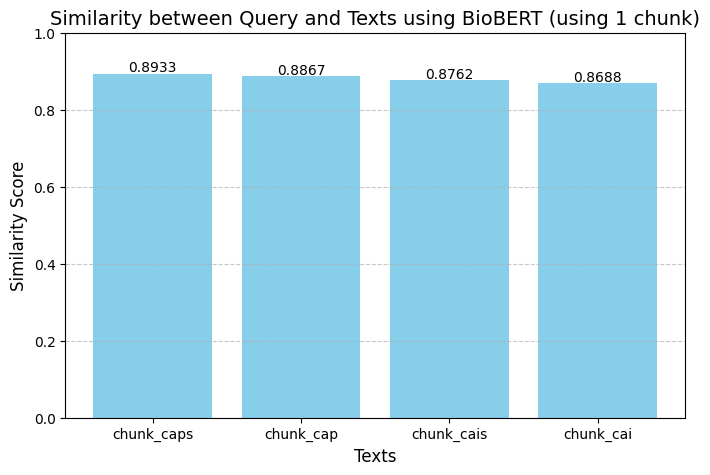

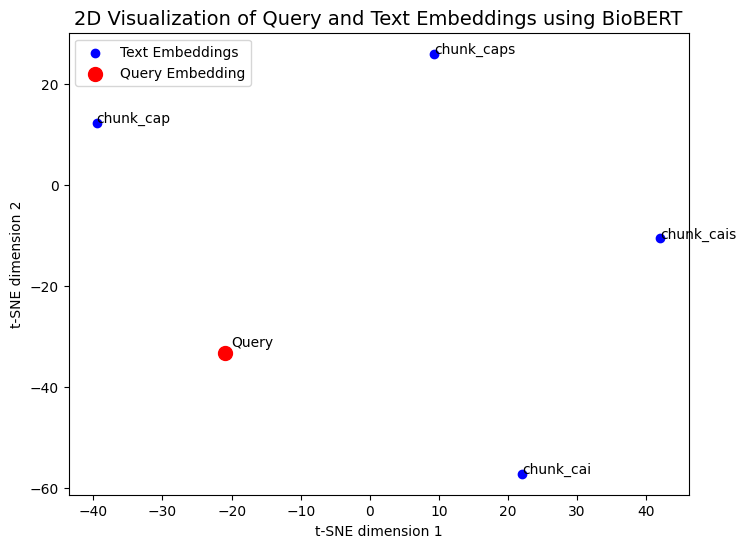

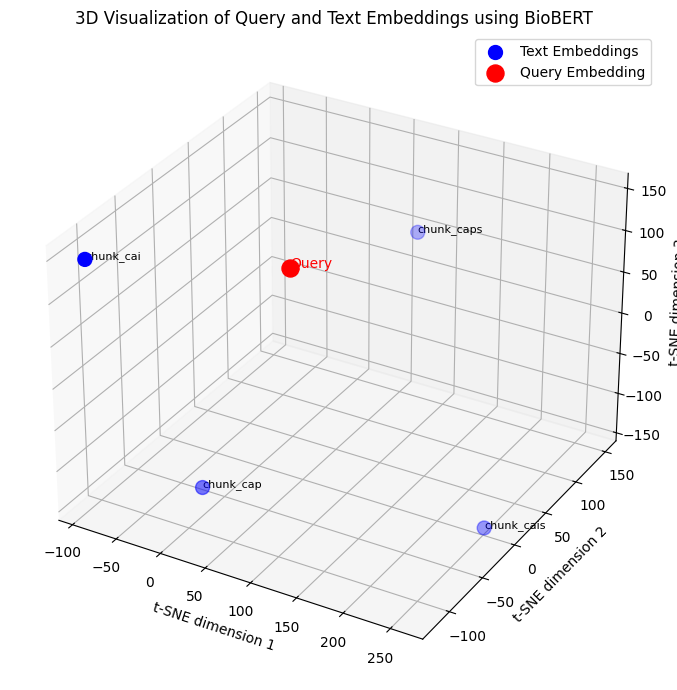

In [159]:
#BioBERT MODEL
get_similarity_scores(biobert_similarity, "BioBERT")

plot_embeddings_tsne_2d(user_query_biobert_embeddings, biobert_embeddings, "BioBERT")

plot_embeddings_tsne_3d(user_query_biobert_embeddings, biobert_embeddings, "BioBERT")

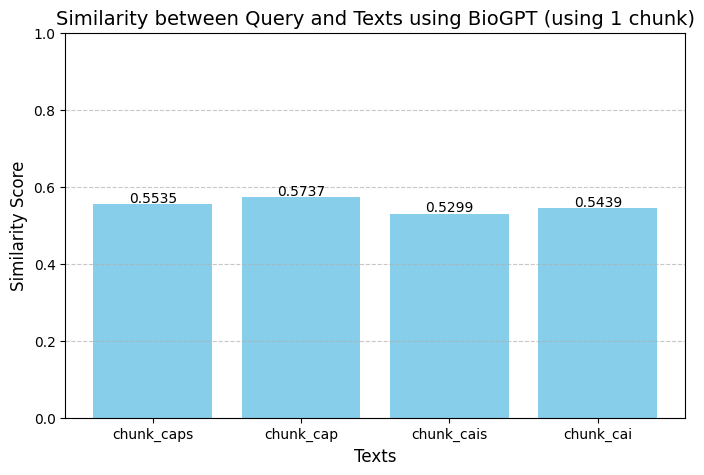

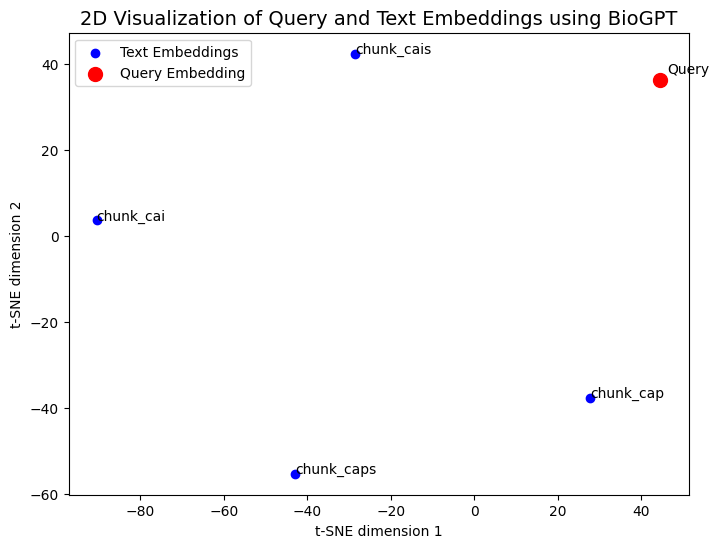

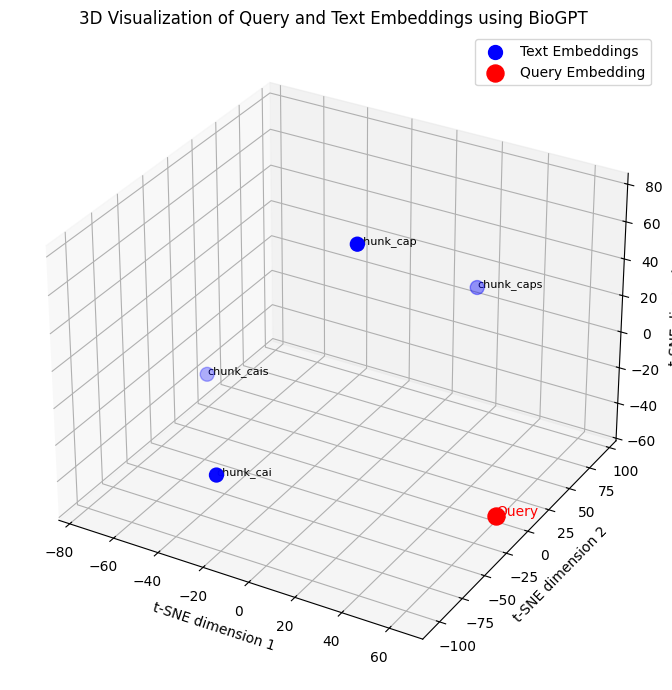

In [142]:
#BioGPT MODEL
get_similarity_scores(biogpt_similarity, "BioGPT")

plot_embeddings_tsne_2d(user_query_biogpt_embeddings, biogpt_embeddings, "BioGPT")

plot_embeddings_tsne_3d(user_query_biogpt_embeddings, biogpt_embeddings, "BioGPT")

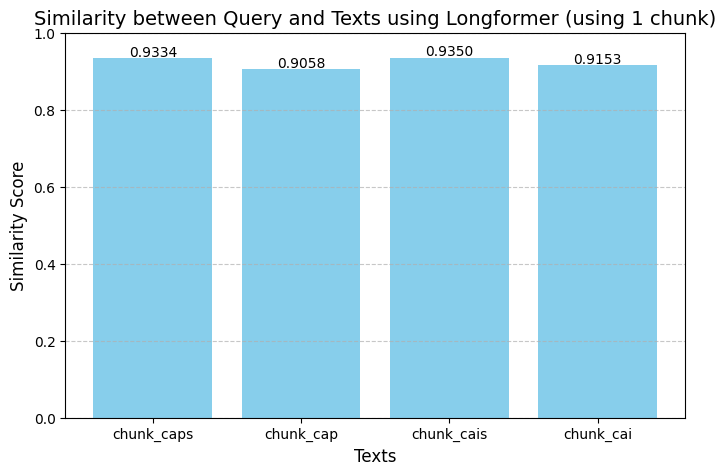

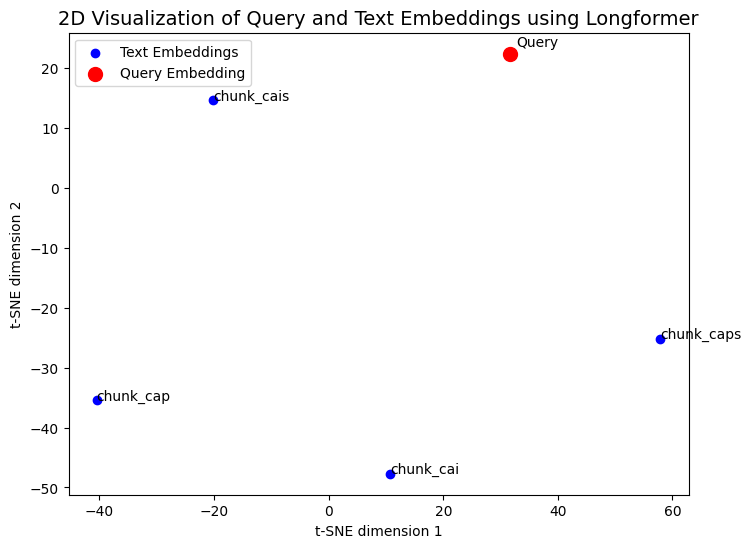

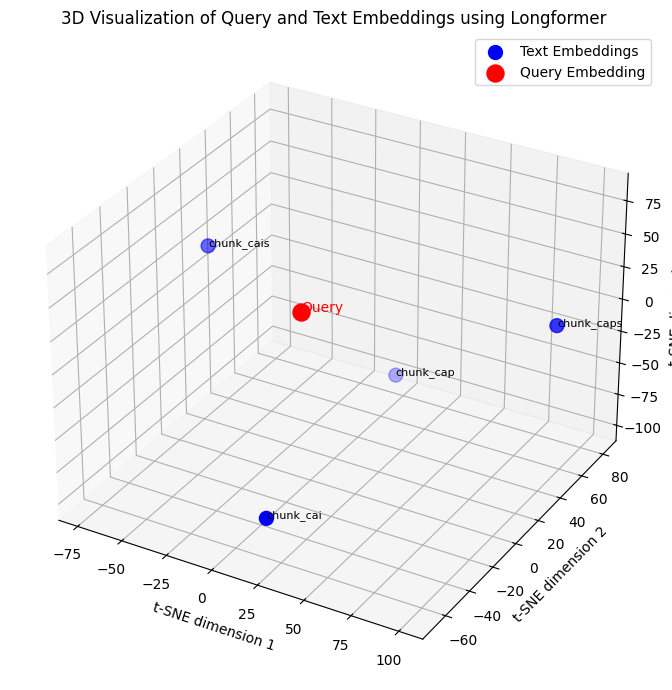

In [143]:
#Longformer MODEL
get_similarity_scores(longformer_similarity, "Longformer")

plot_embeddings_tsne_2d(user_query_longformer_embeddings, longformer_embeddings, "Longformer")

plot_embeddings_tsne_3d(user_query_longformer_embeddings, longformer_embeddings, "Longformer")

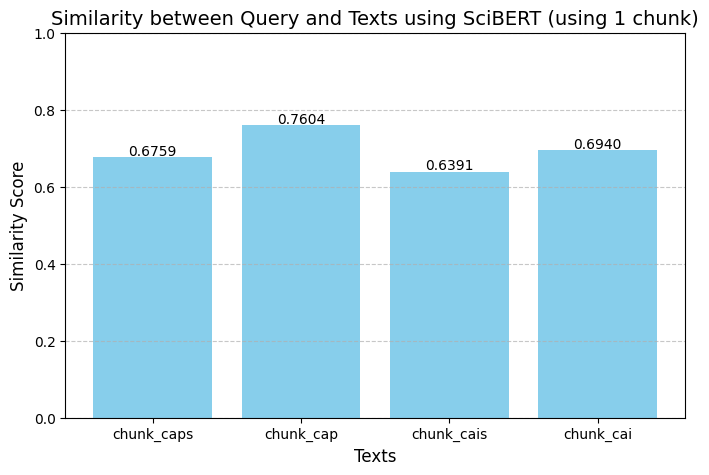

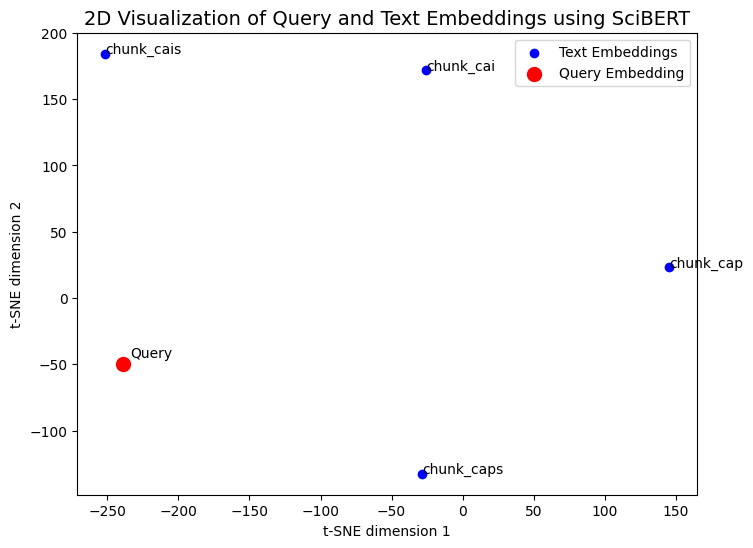

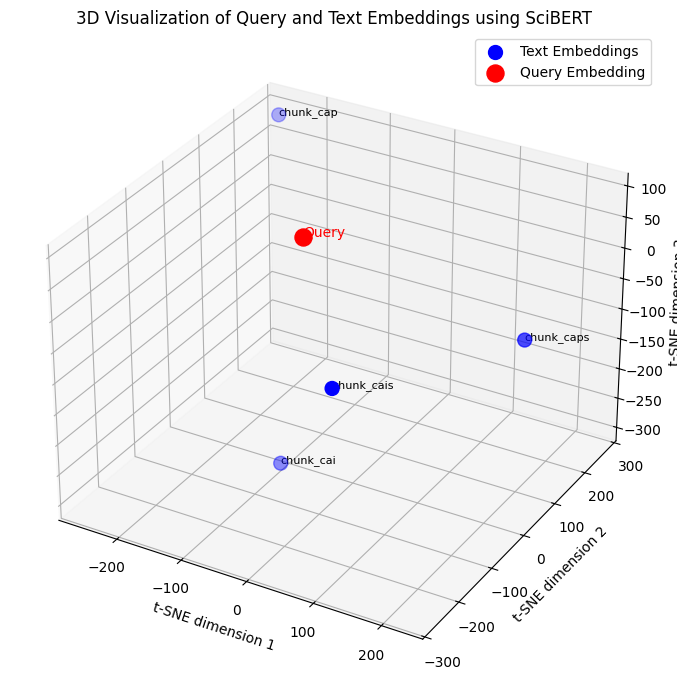

In [144]:
#SciBERT MODEL
get_similarity_scores(scibert_similarity, "SciBERT")

plot_embeddings_tsne_2d(user_query_scibert_embeddings, scibert_embeddings, "SciBERT")

plot_embeddings_tsne_3d(user_query_scibert_embeddings, scibert_embeddings, "SciBERT")

END

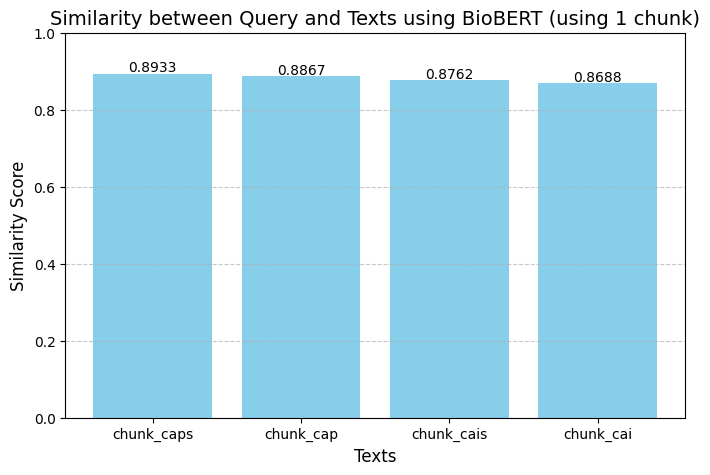

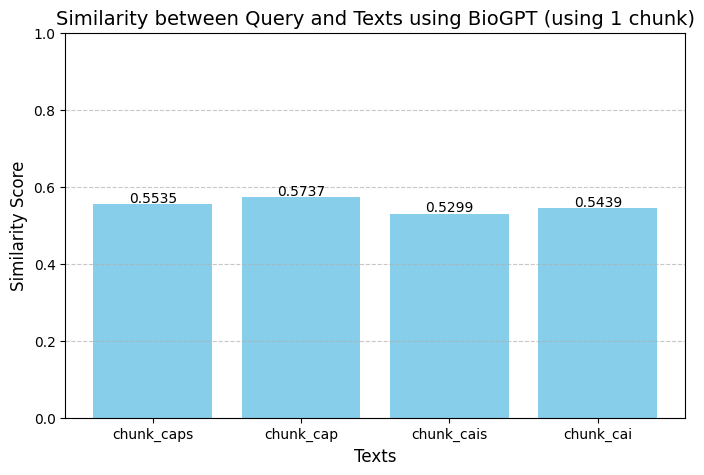

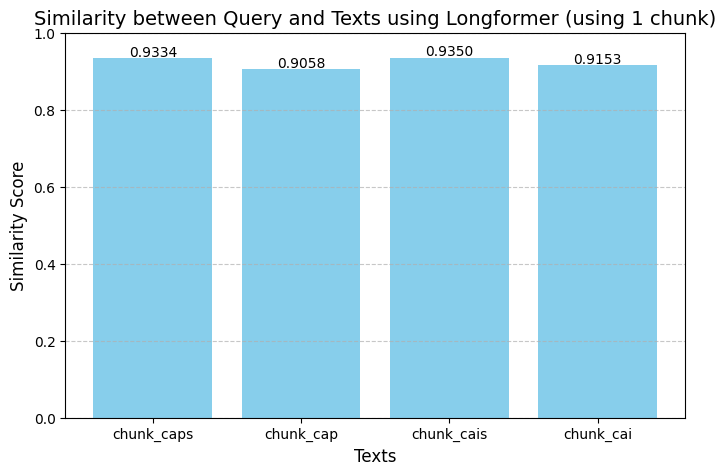

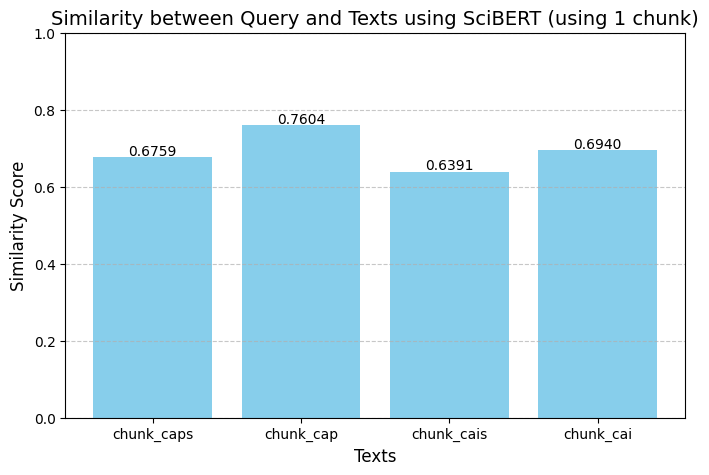

In [35]:
get_similarity_scores(biobert_similarity, "BioBERT")

get_similarity_scores(biogpt_similarity, "BioGPT")

get_similarity_scores(longformer_similarity, "Longformer")

get_similarity_scores(scibert_similarity, "SciBERT")

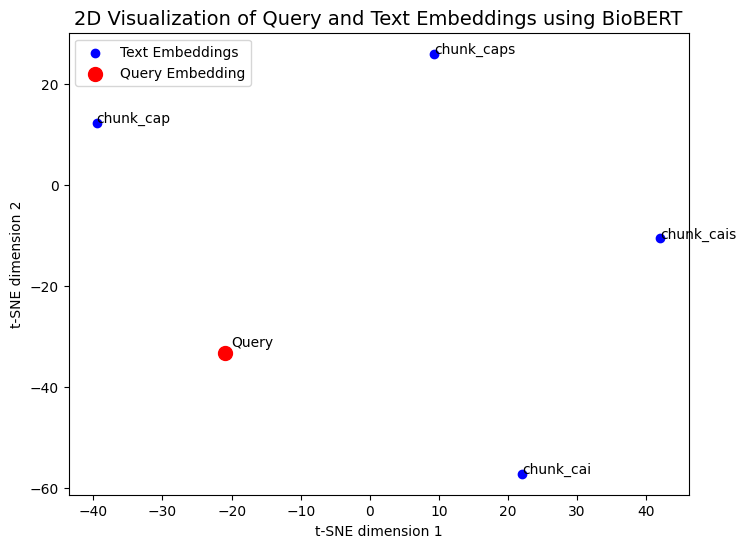

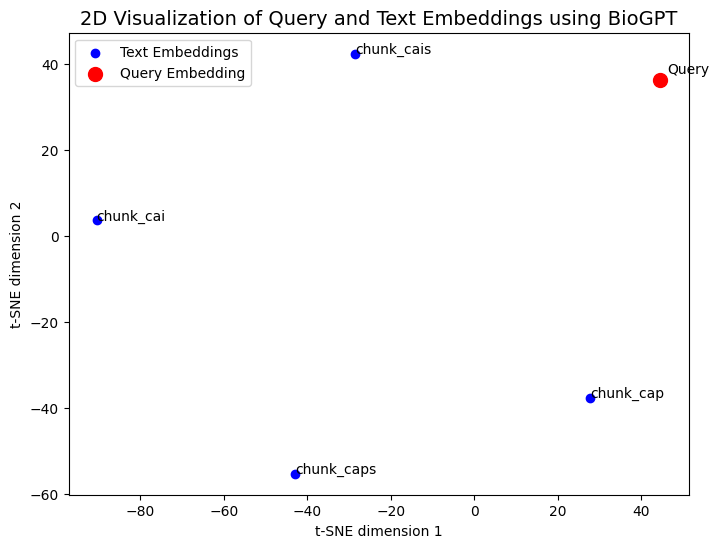

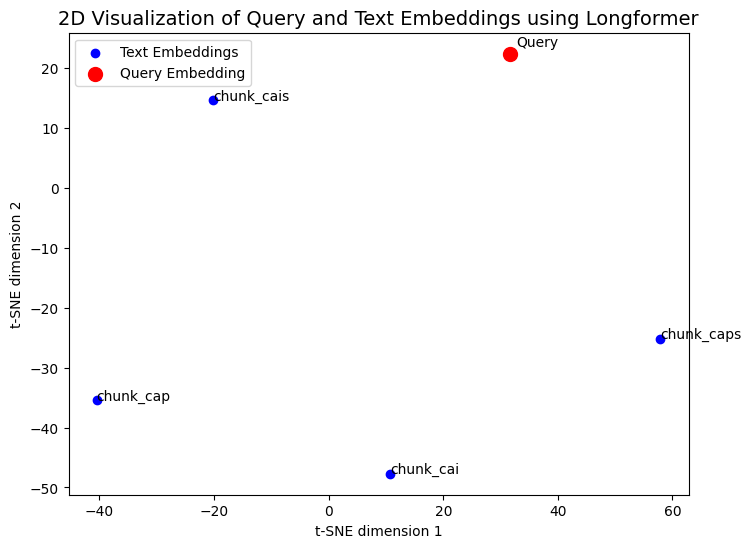

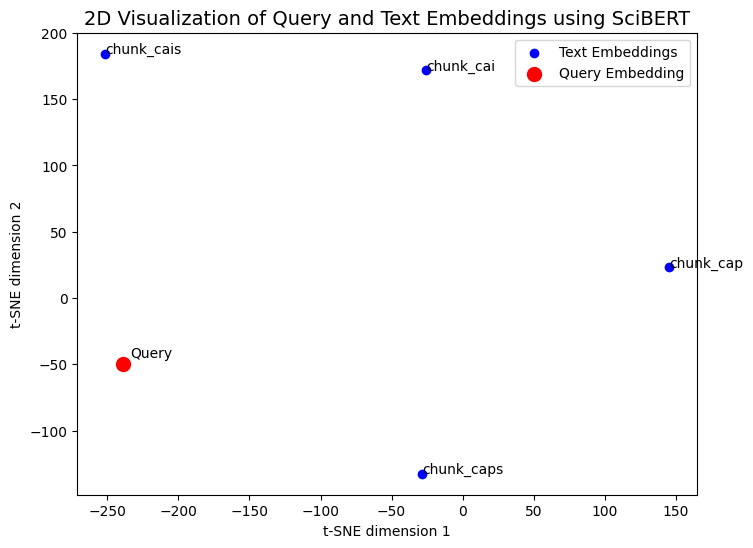

In [125]:
# Plot the embeddings using t-SNE in 2D
plot_embeddings_tsne_2d(user_query_biobert_embeddings, biobert_embeddings, "BioBERT")

plot_embeddings_tsne_2d(user_query_biogpt_embeddings, biogpt_embeddings, "BioGPT")

plot_embeddings_tsne_2d(user_query_longformer_embeddings, longformer_embeddings, "Longformer")

plot_embeddings_tsne_2d(user_query_scibert_embeddings, scibert_embeddings, "SciBERT")


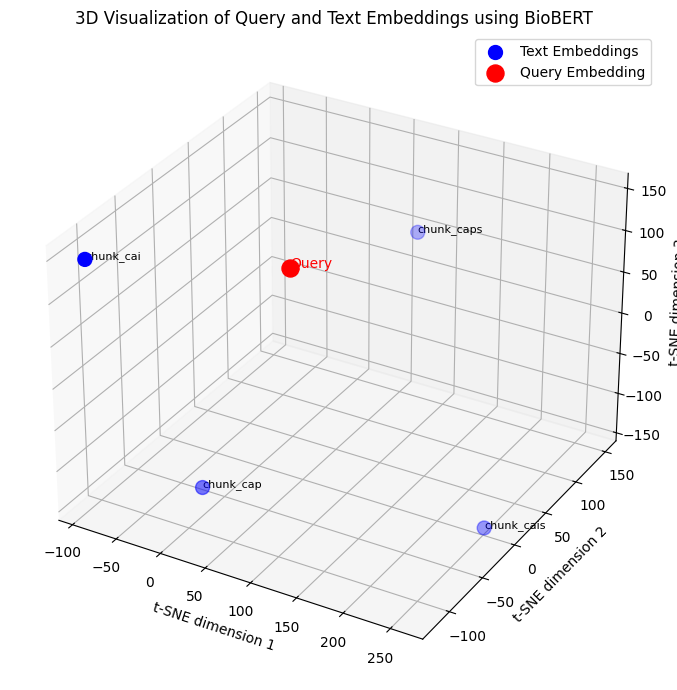

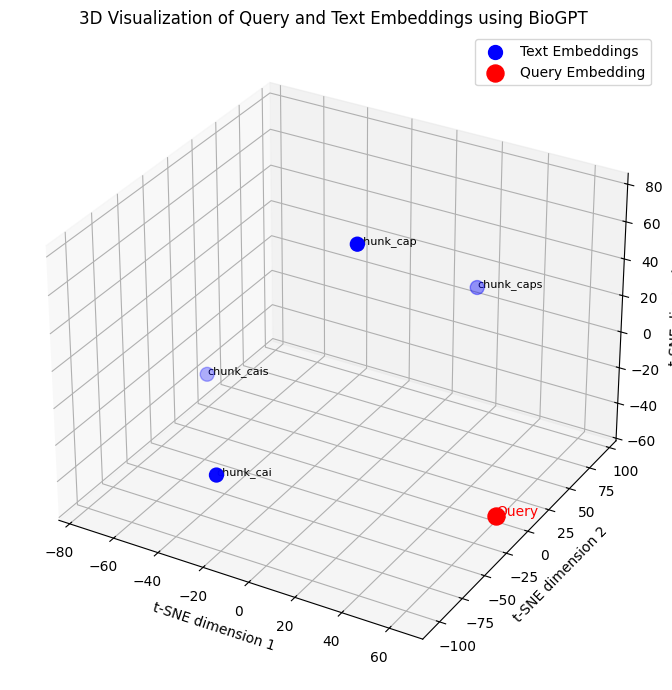

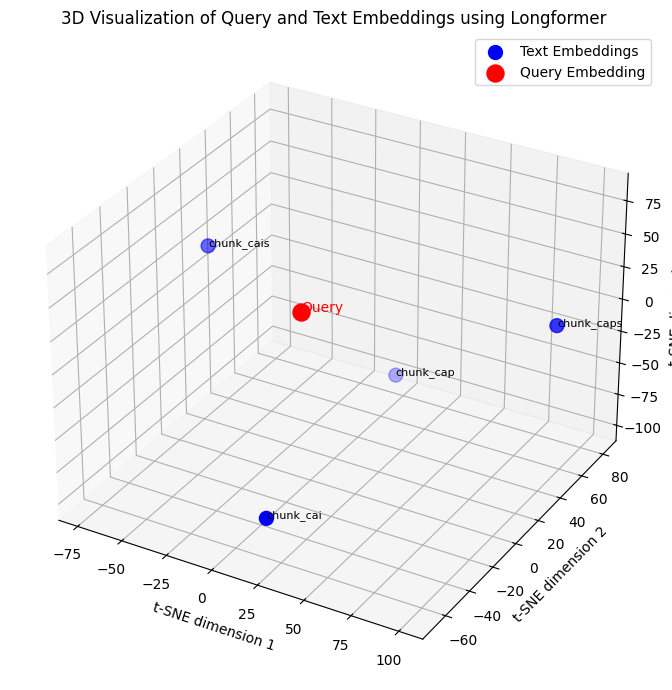

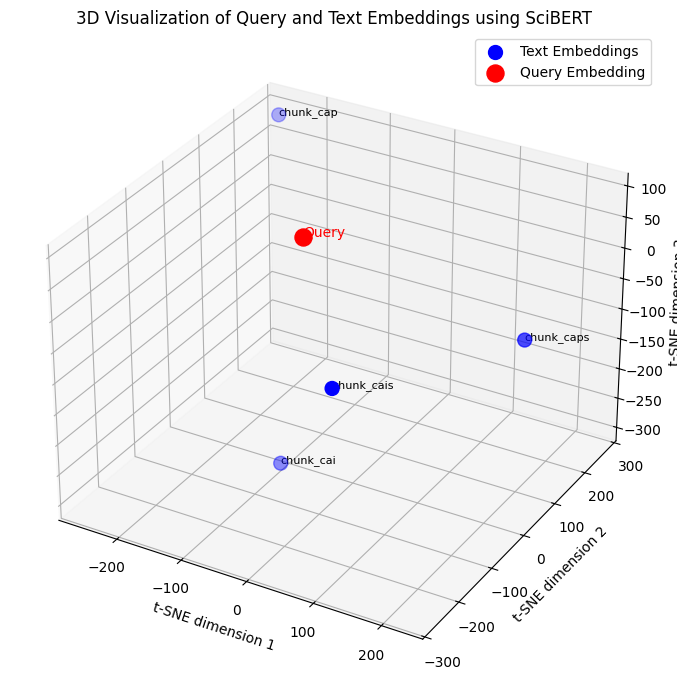

In [134]:
# Plot the embeddings using t-SNE in 3D
plot_embeddings_tsne_3d(user_query_biobert_embeddings, biobert_embeddings, "BioBERT")

plot_embeddings_tsne_3d(user_query_biogpt_embeddings, biogpt_embeddings, "BioGPT")

plot_embeddings_tsne_3d(user_query_longformer_embeddings, longformer_embeddings, "Longformer")

plot_embeddings_tsne_3d(user_query_scibert_embeddings, scibert_embeddings, "SciBERT")

In [ ]:
# For each model

# (I) BioBERT

## Mathematically:
#### Cosine Simillarity check per model
#### Eucledian Simillarity check per model

## Visually:
## Visualize the embeddings
## Visualize how close the embeddings are to the user query

# (II) BioGPT

## Mathematically:
#### Cosine Simillarity check per model
#### Eucledian Simillarity check per model

## Visually:
## Visualize the embeddings
## Visualize how close the embeddings are to the user query

# (III) Longformer

## Mathematically:
#### Cosine Simillarity check per model
#### Eucledian Simillarity check per model

## Visually:
## Visualize the embeddings
## Visualize how close the embeddings are to the user query


